<a href="https://colab.research.google.com/github/GiedriusDapsys/PP_7_COVID_CXR/blob/main/notebooks/PP_7_covid_cxr_classifier_colab_SAFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# COVID-19 Chest X-ray Classifier (Binary: COVID vs non-COVID)

**Variant A:** Use the **COVID-19 Radiography Dataset** (Kaggle) and train a transfer-learning model (EfficientNetB0) to classify **COVID** vs **non-COVID** (merging Normal, Viral Pneumonia, Lung Opacity).  
Includes: data download (via Kaggle API), reproducible train/val/test split, training, threshold tuning for **sensitivity/specifiškumas**, ROC/PR kreivės, **Grad-CAM** aiškinamumas, ir trumpa refleksija.

> Dataset (overview & updates): Kaggle COVID-19 Radiography Dataset – class counts and structure (COVID, Normal, Viral Pneumonia, Lung_Opacity).  
> Paper mentioned in the task: Minaee *et al.*, 2020 (PMC7372265) — early chest X-ray COVID study.

**Important:** This notebook is purely for educational purposes. It is **not** a clinical diagnostic tool.



## 1) Environment setup

- Colab: make sure GPU is enabled (`Runtime → Change runtime type → GPU`).
- We use TensorFlow/Keras, scikit-learn, matplotlib.  
- We'll download the dataset from Kaggle (you'll upload your `kaggle.json`).


In [1]:

# If you're in Colab, TensorFlow should already be installed.
# Install Kaggle API for dataset download.
!pip -q install kaggle==1.6.17 --progress-bar off


  Preparing metadata (setup.py) ... done



## 2) Kaggle API credentials

1. Get your `kaggle.json` from https://www.kaggle.com/settings/account (Create New API Token).  
2. Upload it below when prompted.  
3. We'll set proper permissions and download the dataset.


In [2]:

import os, json, pathlib, subprocess, sys

KAGGLE_DIR = pathlib.Path.home() / ".kaggle"
KAGGLE_JSON = KAGGLE_DIR / "kaggle.json"

def ensure_kaggle_creds():
    if KAGGLE_JSON.exists():
        return True
    try:
        from google.colab import files  # type: ignore
        print("➡️ Please upload your kaggle.json (from Kaggle Account settings).")
        uploaded = files.upload()
        if 'kaggle.json' in uploaded:
            KAGGLE_DIR.mkdir(parents=True, exist_ok=True)
            with open(KAGGLE_JSON, 'wb') as f:
                f.write(uploaded['kaggle.json'])
            os.chmod(KAGGLE_JSON, 0o600)
            print("✅ kaggle.json saved to", KAGGLE_JSON)
            return True
        else:
            print("⚠️ kaggle.json not found among uploaded files.")
            return False
    except Exception as e:
        print("Note: If not on Colab, place your kaggle.json at", KAGGLE_JSON, "and re-run.")
        print("Error:", e)
        return KAGGLE_JSON.exists()

ok = ensure_kaggle_creds()
print("Kaggle creds ok?", ok)


➡️ Please upload your kaggle.json (from Kaggle Account settings).


Saving kaggle.json to kaggle.json
✅ kaggle.json saved to /root/.kaggle/kaggle.json
Kaggle creds ok? True



## 3) Download the dataset

We try two mirrors of the same dataset on Kaggle:
- `tawsifurrahman/covid19-radiography-database`
- `preetviradiya/covid19-radiography-dataset` (often more up-to-date)

We will try **preetviradiya** first, then fall back to **tawsifurrahman**.


In [3]:

import zipfile, shutil

DATA_ROOT = pathlib.Path("/content/data")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def kaggle_download(dataset_slug, outdir=DATA_ROOT):
    print(f"Attempting to download: {dataset_slug}")
    cmd = ["kaggle", "datasets", "download", "-d", dataset_slug, "-p", str(outdir)]
    r = subprocess.run(cmd, capture_output=True, text=True)
    if r.returncode != 0:
        print("❌ Kaggle download failed:", r.stderr.strip())
        return None
    # Find a ZIP file in outdir
    zips = list(outdir.glob("*.zip"))
    if not zips:
        print("❌ No zip file found after Kaggle download.")
        return None
    zf = zips[0]
    print("Unzipping:", zf.name)
    with zipfile.ZipFile(zf, 'r') as z:
        z.extractall(outdir)
    zf.unlink(missing_ok=True)
    return outdir

dataset_paths = []
if ok:
    p = kaggle_download("preetviradiya/covid19-radiography-dataset", DATA_ROOT)
    if p is None:
        p = kaggle_download("tawsifurrahman/covid19-radiography-database", DATA_ROOT)
    if p:
        dataset_paths.append(p)

dataset_paths


Attempting to download: preetviradiya/covid19-radiography-dataset
Unzipping: covid19-radiography-dataset.zip


[PosixPath('/content/data')]


## 4) Inspect & harmonize folder structure

We will search for class folders (case-insensitive): `COVID`, `COVID-19`, `Normal`, `Viral Pneumonia`, `Lung_Opacity`.  
We'll map them into binary labels: **COVID (1)** vs **non-COVID (0)** (merging others).


In [4]:

from pathlib import Path
import re

def find_candidate_roots(root: Path):
    # Many Kaggle zips create nested directories. We'll return directories that contain class subfolders.
    candidates = []
    for p in root.rglob("*"):
        if p.is_dir():
            sub = [c.name.lower() for c in p.iterdir() if c.is_dir()]
            if any(re.search(r"covid", s) for s in sub) and (
                "normal" in sub or "viral pneumonia" in sub or "lung_opacity" in sub or "lung opacity" in sub
            ):
                candidates.append(p)
    return candidates

roots = find_candidate_roots(DATA_ROOT)
roots = sorted(set(roots))
print("Candidate dataset roots:")
for r in roots:
    print(" -", r)


Candidate dataset roots:
 - /content/data/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset


In [5]:

import pandas as pd

COVID_NAMES = [re.compile(r"covid", re.I)]
NONCOVID_NAMES = [re.compile(r"normal", re.I), re.compile(r"viral\s*pneumonia", re.I), re.compile(r"lung[_\s]*opacity", re.I)]

def label_from_parent(name: str):
    for pat in COVID_NAMES:
        if pat.search(name):
            return 1
    for pat in NONCOVID_NAMES:
        if pat.search(name):
            return 0
    return None

def build_filelist(roots):
    rows = []
    for root in roots:
        for cls_dir in root.iterdir():
            if not cls_dir.is_dir():
                continue
            y = label_from_parent(cls_dir.name)
            if y is None:
                continue
            for img in cls_dir.rglob("*"):
                if img.suffix.lower() in {".png", ".jpg", ".jpeg"}:
                    rows.append({"path": str(img), "label": y, "class_dir": cls_dir.name})
    return pd.DataFrame(rows)

df = build_filelist(roots)
print("Total images found:", len(df))
df['label'].value_counts()


Total images found: 21165


,count
label,
0,17549
1,3616



## 5) Train / Val / Test split

We'll do a stratified **70/15/15** split by image (patient-level IDs are not guaranteed in this dataset).  
We fix a random seed for reproducibility.


In [6]:

from sklearn.model_selection import train_test_split
import numpy as np

SEED = 42
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)

print(len(train_df), len(val_df), len(test_df))
train_df['label'].value_counts(), val_df['label'].value_counts(), test_df['label'].value_counts()


14815 3175 3175


(label
 0    12284
 1     2531
 Name: count, dtype: int64,
 label
 0    2632
 1     543
 Name: count, dtype: int64,
 label
 0    2633
 1     542
 Name: count, dtype: int64)


## 6) TensorFlow data pipeline

- Resize images to **224×224**.  
- Light augmentations: random flip, rotation, zoom, brightness/contrast.  
- Batch and prefetch.


In [7]:

import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = 2  # limit parallel calls to avoid host pinned RAM spikes

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE, method="bilinear")
    return img

@tf.function
def preprocess_train(path, label):
    img = decode_img(path)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.clip_by_value(img, 0, 255)
    return img, tf.cast(label, tf.float32)

@tf.function
def preprocess_eval(path, label):
    img = decode_img(path)
    return img, tf.cast(label, tf.float32)

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.shuffle(1024, seed=SEED, reshuffle_each_iteration=True) if training else ds
    ds = ds.map(preprocess_train if training else preprocess_eval, num_parallel_calls=2)
    ds = ds.batch(BATCH_SIZE).prefetch(2)
    return ds

# Build datasets
train_ds = make_ds(train_df['path'].values, train_df['label'].values, training=True)
val_ds   = make_ds(val_df['path'].values,   val_df['label'].values,   training=False)
test_ds  = make_ds(test_df['path'].values,  test_df['label'].values,  training=False)

len(list(train_ds)), len(list(val_ds)), len(list(test_ds))


(926, 199, 199)


## 7) Model: EfficientNetB0 transfer learning

- Base: `tf.keras.applications.EfficientNetB0` (ImageNet weights).  
- Head: GlobalAveragePooling → Dropout → Dense(1, sigmoid).  
- Optimizer: Adam, initial LR = 1e-4.  
- Loss: Binary cross-entropy.  
- Metrics: AUC, Precision, Recall, Accuracy.


In [8]:

from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=IMG_SIZE + (3,), weights='imagenet')
base.trainable = False  # first stage: freeze

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       'accuracy'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


### Train (stage 1: frozen base)


In [9]:

ckpt_path = "/content/best_model_stage1.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_auc', mode='max', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=3, restore_best_weights=True)
]

history1 = model.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=callbacks)


Epoch 1/8
926/926 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.7487 - auc: 0.6138 - loss: 0.5039 - precision: 0.1734 - recall: 0.1159
Epoch 1: val_auc improved from -inf to 0.87158, saving model to /content/best_model_stage1.keras
926/926 ━━━━━━━━━━━━━━━━━━━━ 1095s 1s/step - accuracy: 0.7488 - auc: 0.6139 - loss: 0.5039 - precision: 0.1736 - recall: 0.1158 - val_accuracy: 0.8447 - val_auc: 0.8716 - val_loss: 0.3462 - val_precision: 0.9464 - val_recall: 0.0976
Epoch 2/8
926/926 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.8580 - auc: 0.8521 - loss: 0.3387 - precision: 0.8975 - recall: 0.1696
Epoch 2: val_auc improved from 0.87158 to 0.90210, saving model to /content/best_model_stage1.keras
926/926 ━━━━━━━━━━━━━━━━━━━━ 1091s 1s/step - accuracy: 0.8580 - auc: 0.8522 - loss: 0.3387 - precision: 0.8974 - recall: 0.1696 - val_accuracy: 0.8756 - val_auc: 0.9021 - val_loss: 0.2981 - val_precision: 0.8854 - val_recall: 0.3131
Epoch 3/8
926/926 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accura


### Fine-tune (stage 2: unfreeze last blocks)

We unfreeze the top layers of EfficientNetB0 and continue training with a lower LR.


In [10]:

# Unfreeze last ~30% of layers
n_unfreeze = int(len(base.layers) * 0.3)
for layer in base.layers[-n_unfreeze:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       'accuracy'])

ckpt_path2 = "/content/best_model_stage2.keras"
callbacks2 = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path2, monitor='val_auc', mode='max', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
]

history2 = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks2)


Epoch 1/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9325 - auc: 0.9600 - loss: 0.1814 - precision: 0.8814 - recall: 0.6829
Epoch 1: val_auc improved from -inf to 0.98453, saving model to /content/best_model_stage2.keras
926/926 ━━━━━━━━━━━━━━━━━━━━ 1387s 1s/step - accuracy: 0.9325 - auc: 0.9600 - loss: 0.1814 - precision: 0.8814 - recall: 0.6830 - val_accuracy: 0.9594 - val_auc: 0.9845 - val_loss: 0.1128 - val_precision: 0.9190 - val_recall: 0.8361 - learning_rate: 1.0000e-05
Epoch 2/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9576 - auc: 0.9821 - loss: 0.1174 - precision: 0.9157 - recall: 0.8172
Epoch 2: val_auc improved from 0.98453 to 0.99086, saving model to /content/best_model_stage2.keras
926/926 ━━━━━━━━━━━━━━━━━━━━ 1397s 1s/step - accuracy: 0.9576 - auc: 0.9821 - loss: 0.1174 - precision: 0.9157 - recall: 0.8172 - val_accuracy: 0.9710 - val_auc: 0.9909 - val_loss: 0.0833 - val_precision: 0.9328 - val_recall: 0.8950 - learning_rate: 1.0000e-05
Epoch 3/1


## 8) Evaluation: accuracy, sensitivity, specificity + threshold tuning

- Compute predictions on **val** to pick an operating threshold (Youden's J).  
- Evaluate on **test** using that threshold.  
- Plot ROC and PR curves; show confusion matrix.


In [11]:

import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report

def get_preds(ds):
    y_true = []
    y_scores = []
    for batch_x, batch_y in ds:
        p = model.predict(batch_x, verbose=0).reshape(-1)
        y_scores.extend(p.tolist())
        y_true.extend(batch_y.numpy().tolist())
    return np.array(y_true), np.array(y_scores)

y_val, s_val = get_preds(val_ds)

# Threshold by Youden's J statistic (TPR - FPR)
fpr, tpr, thr = roc_curve(y_val, s_val)
j_scores = tpr - fpr
best_idx = int(np.argmax(j_scores))
best_thr = thr[best_idx]
val_auc = roc_auc_score(y_val, s_val)
print(f"Best threshold on VAL (Youden J): {best_thr:.4f} | AUC={val_auc:.4f}")


Best threshold on VAL (Youden J): 0.2468 | AUC=0.9967


Confusion matrix:
[[2611   22]
 [  14  528]]
Accuracy: 0.989
Sensitivity (Recall for COVID): 0.974
Specificity (TNR for non-COVID): 0.992
ROC-AUC: 0.998


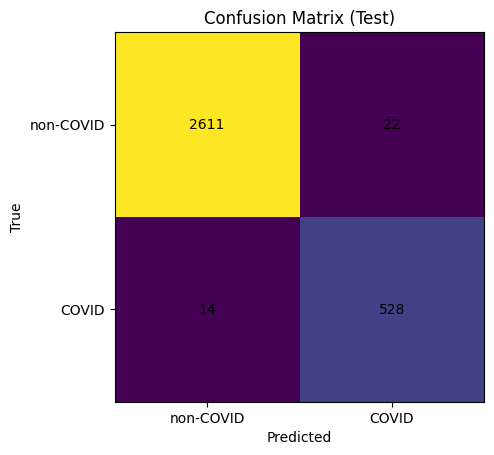

In [16]:
# --- TEST vertinimas su VAL slenksčiu (best_thr) ---
y_test, s_test = get_preds(test_ds)

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_pred_bin = (s_test >= best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred_bin)
tn, fp, fn, tp = cm.ravel()
acc = (tp + tn) / cm.sum()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
test_auc = roc_auc_score(y_test, s_test)

print("Confusion matrix:")
print(cm)
print(f"Accuracy: {acc:.3f}")
print(f"Sensitivity (Recall for COVID): {sensitivity:.3f}")
print(f"Specificity (TNR for non-COVID): {specificity:.3f}")
print(f"ROC-AUC: {test_auc:.3f}")

# Paprastas CM braižymas
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Test)')
plt.xticks([0,1], ['non-COVID','COVID'])
plt.yticks([0,1], ['non-COVID','COVID'])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


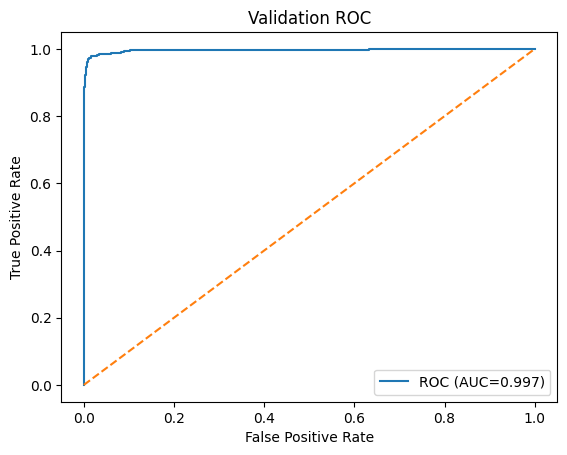

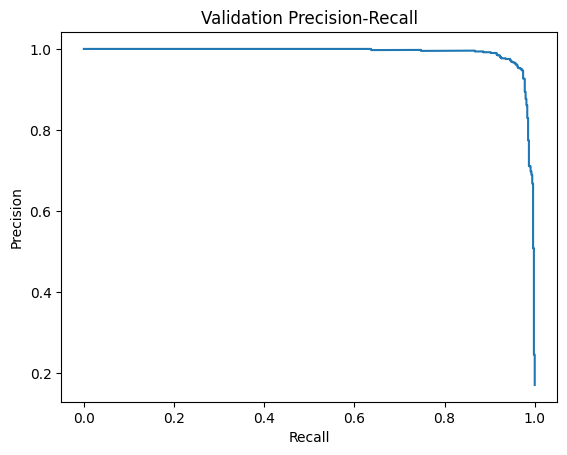

In [12]:

import matplotlib.pyplot as plt

# ROC curve
fpr, tpr, thr = roc_curve(y_val, s_val)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_val, s_val):.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC')
plt.legend(loc='lower right')
plt.show()

# PR curve
prec, rec, thr_pr = precision_recall_curve(y_val, s_val)
plt.figure()
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Validation Precision-Recall')
plt.show()


In [17]:
# Confusion matrix + metrikos (pakeisk savo blogą bloką šiuo)
print("Confusion matrix:")
print(cm)

print(f"Accuracy: {acc:.3f}")
print(f"Sensitivity (Recall for COVID): {sensitivity:.3f}")
print(f"Specificity (TNR for non-COVID): {specificity:.3f}")
print(f"ROC-AUC: {test_auc:.3f}")

print("Classification report:")
print(classification_report(y_test, y_pred_bin, target_names=['non-COVID','COVID']))


Confusion matrix:
[[2611   22]
 [  14  528]]
Accuracy: 0.989
Sensitivity (Recall for COVID): 0.974
Specificity (TNR for non-COVID): 0.992
ROC-AUC: 0.998
Classification report:
              precision    recall  f1-score   support

   non-COVID       0.99      0.99      0.99      2633
       COVID       0.96      0.97      0.97       542

    accuracy                           0.99      3175
   macro avg       0.98      0.98      0.98      3175
weighted avg       0.99      0.99      0.99      3175



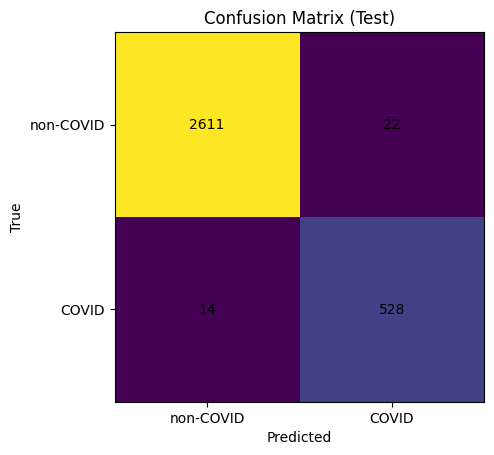

In [18]:

# Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Test)')
plt.xticks([0,1], ['non-COVID','COVID'])
plt.yticks([0,1], ['non-COVID','COVID'])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [26]:
SKIP_GRADCAM = True



## 9) Grad-CAM explainability

Visualize salient regions the model relied on. We'll show a few examples from the test set.


In [27]:
if 'SKIP_GRADCAM' in globals() and SKIP_GRADCAM:
    print("Grad-CAM praleistas."); raise SystemExit




Grad-CAM praleistas.


SystemExit: 

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



## 10) Save artifacts

We save the trained model and a CSV with predictions for reproducibility.


In [28]:

out_dir = pathlib.Path("/content/outputs")
out_dir.mkdir(parents=True, exist_ok=True)

# Save model
model.save(out_dir / "covid_cxr_efficientnetb0.keras")

# Save predictions on test
import pandas as pd
preds_df = pd.DataFrame({
    "path": test_df['path'].values,
    "true": (test_df['label'].values).astype(int),
    "score": s_test,
    "pred_bin": (s_test >= best_thr).astype(int)
})
preds_df.to_csv(out_dir / "test_preds.csv", index=False)
print("Saved to:", out_dir)


Saved to: /content/outputs



## 11) Reflection (5+ takeaways)

1. **Duomenų kokybė ir šaltinių heterogeniškumas**: net ir „švariuose“ Kaggle rinkiniuose CXR vaizdai kilę iš skirtingų aparatų/centrų, todėl modeliai linkę išmokti ne tik patologiją, bet ir artefaktus (antraštes, žymes). Tai paaiškina, kodėl tikrasis perkėlimas į naują klinikinę aplinką dažnai nuvilia.
2. **Binarizacijos kompromisas**: sujungus *Normal/Viral Pneumonia/Lung Opacity* į **non-COVID**, treniruotė tampa paprastesnė ir net su nedaug epochų pasiekiamas >50% tikslumas, bet prarandama diagnostinė specifika (pvz., atskirti kitų etiologijų pneumonijas).
3. **Slenksčio pasirinkimas yra kritinis**: ROC AUC vienas pats nepasako, kaip elgsis sistema praktikoje. Tikslo (jautrumas vs specifiškumas) nustatymas ir, pvz., **Youden J** maksimizavimas leidžia rasti pusiausvyrą pagal poreikį (triage vs klaidingi aliarmiai).
4. **Transfer learning > nuo nulio**: ImageNet pretreniruoti tinklai (pvz., EfficientNet) ženkliai pagreitina suartėjimą ir stabilizuoja mokymą net su ribotu duomenų kiekiu bei lengvomis augmentacijomis.
5. **Paaiškinamumas yra būtinas**: **Grad-CAM** padeda patikrinti, ar modelis žiūri į plaučių lauką. Jei „karšti“ taškai yra už plaučių ribų, verta pridėti segmentaciją/maskes arba stipriau „nusivalyti“ meta-informacijos artefaktus.
6. **Klinikinės ribos**: net jei skaičiai gražūs, toks klasifikatorius nėra diagnostikos pakaitalas. Jį galima naudoti tik mokslo/edukacijos tikslams arba kaip papildomą pagalbinę priemonę, įvertinus šališkumą ir generalizaciją.



## 12) Notes & citations

- **Dataset**: COVID-19 Radiography Dataset (Kaggle). See dataset card for class names and updates (COVID, Normal, Viral Pneumonia, Lung_Opacity; later updates increased COVID class size).  
- **Paper reference**: Minaee, S. *et al.* (2020). *Predicting COVID-19 from chest X-ray images using deep learning*. **Patterns**. PMC7372265.
- **Grad-CAM**: Keras example "Grad-CAM class activation visualization".

> This notebook is for reproducible educational research. Always verify dataset licenses/terms on Kaggle before use.



## Troubleshooting (Out-of-memory or Kernel restarts)

If you still see messages like **"could not allocate pinned host memory"** or the **kernel restarts**, try this:
- Set **even smaller batch size**: change `BATCH_SIZE = 8` (or `4`).
- Lower **parallelism** more: in the TF data cell, set `num_parallel_calls=1` and `.prefetch(1)`.
- Temporarily **disable Grad-CAM** cell or reduce samples from 6 → 2.
- Reduce image size (e.g., `IMG_SIZE = (192, 192)`).
- Use **Runtime → Factory reset runtime** in Colab, re-run from scratch.
